In [1]:
import warnings
from pathlib import Path

import numpy as np
import pytorch_lightning as pl
import torch
from matplotlib import pyplot as plt
from pytorch_lightning import loggers as pl_loggers
from pytorch_lightning.callbacks import RichProgressBar

In [2]:
from zprp.models.cycle_gan.data import CycleGanDataModule
from zprp.models.cycle_gan.model import CycleGAN

In [3]:
LOG_PATH = "lightning_logs"
LOG_NAME = "cyclegan_example"
DATA_PATH = Path("../data")

In [4]:
torch.set_float32_matmul_precision("high")
# lightning complaining about using only one worker in DataLoader
warnings.filterwarnings("ignore", ".*does not have many workers.*")

In [5]:
CONTENT_PATH = DATA_PATH / "photo/0"
STYLE_PATH = DATA_PATH / "monet/0"

In [6]:
def unnormalize(x: torch.Tensor) -> torch.Tensor:
    return (x * 0.5) + 0.5

torch.float32


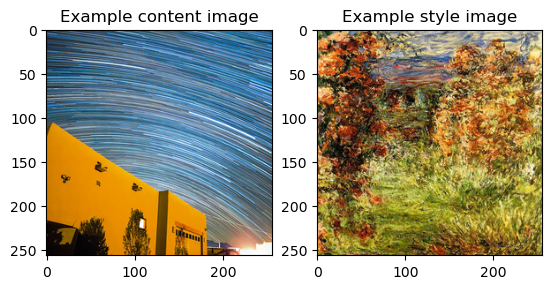

In [7]:
dm = CycleGanDataModule(content_path=CONTENT_PATH, style_path=STYLE_PATH, n_val_images=64)
dm.setup("fit")

content_img, style_img = next(iter(dm.train_dataloader()))

print(content_img.dtype)

fix, axes = plt.subplots(1, 2)

axes[0].imshow(np.transpose(unnormalize(content_img[0]), axes=(1, 2, 0)))
axes[0].set_title("Example content image")
axes[1].imshow(np.transpose(unnormalize(style_img[0]), axes=(1, 2, 0)))
axes[1].set_title("Example style image")
plt.show()

In [8]:
epochs = 30
tb_logger = pl_loggers.TensorBoardLogger(save_dir=LOG_PATH, name=LOG_NAME)


model = CycleGAN()


trainer = pl.Trainer(
    max_epochs=epochs,
    logger=tb_logger,
    enable_checkpointing=False,
    log_every_n_steps=1,
    callbacks=[RichProgressBar(refresh_rate=10)],
)
trainer.fit(model, dm)

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.rich_model_summary.RichModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name                   ┃ Type                 ┃ Params ┃
┡━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ g                      │ Generator            │ 11.4 M │
│ 1 │ f                      │ Generator            │ 11.4 M │
│ 2 │ dx                     │ Discriminator        │  2.8 M │
│ 3 │ dy                     │ Discriminator        │  2.8 M │
│ 4 │ lsgan_loss             │ LSGANLoss            │      0 │
│ 5 │ cycle_consistency_loss │ CycleConsistencyLoss │      0 │
└───┴────────────────────────┴──────────────────────┴────────┘

Trainable params: 28.3 M                                                                                           
Non-trainable params: 0                                                                                            
Total params: 28.3 M                                                                                               
Total estimated model params size (MB): 113

Output()